## Testing the emulation

This notebook will include one of our networks, and run the inference. Then, the same model will be tested from its hls version, to check that the emulation works. 

For the qkeras and hls4ml tests, this will be based on our framework. For the emulation, this will be based on the "quickstart.py" file that is doing the same for the VAE from the anomaly team.

In [1]:
### first, lets set all required environment variables

! source /scratch/Xilinx/Vivado/2018.3/settings64.sh
! export XILINX_HLS=/scratch/Xilinx/Vivado/2018.3 

In [2]:
import topotrigger_emulation as emu

In [3]:
# and then the framework stuff

# just suppressing the CUDA warnings from keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# suppressing repeated warnings
import warnings
warnings.filterwarnings(action='once')

import numpy as np

# importing the required modules
import sys
sys.path.insert(1, '/scratch/flabe/uhh_mlatl1_run3/src')

from loadData import *
from preprocessing import *
from models import *
from training import *
from utils import *
from plotting import *
from inference import *
from tests import *
from hls4ml_methods import *

from tensorflow import keras
from sklearn.utils import shuffle

set_global_plotting_settings()

/scratch/uh2ml4l1/anaconda3/envs/finns_framework_setup/lib/python3.7/site-packages/tensorflow_model_optimization/__init__.py:65: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.version.VERSION) <
/scratch/uh2ml4l1/anaconda3/envs/finns_framework_setup/lib/python3.7/site-packages/awkward0/__init__.py:8: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(numpy.__version__) < distutils.version.LooseVersion("1.13.1"):
/scratch/uh2ml4l1/anaconda3/envs/finns_framework_setup/lib/python3.7/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [4]:
### definitions

# we'll be using hw values
data_file = "/scratch/flabe/data/h5/hw/NuGun_preprocessed.h5"

# defining the keras model
keras_model = "/scratch/flabe/" + "hhtobbww/models/" + "/newfwkbothchannel_small_compressed/info.yml"

In [5]:
# running a unit test to make sure the model can be properly included

_ = unitTestModel(keras_model, verbosity = 99)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


/scratch/uh2ml4l1/anaconda3/envs/finns_framework_setup/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


4/4 [==============================] - 0s 1ms/step
Unit test success: predictions agree.


In [6]:
# getting the data
_, eventInfo, data, bits = readFromAnomalyBackgroundh5(data_file, verbosity = 99)

# we'll use some events for testing
n_test_events = 100000

data = data[:n_test_events]
bits = bits[:n_test_events]

x_hw = formatDataTopotrigger(data, loadDictionary(keras_model)["objects"]).astype("int")

Reading anomaly team preprocessed background file at /scratch/flabe/data/h5/hw/NuGun_preprocessed.h5.
Starting to read input file...
Done!


In [7]:
# getting the pure keras prediction

scaler = loadScaler( get_path_from_info(keras_model) + loadDictionary(keras_model)["scaler"] ) 
#x = applyScalerAsBitshift(scaler, x_hw)
x = []
for one_x_hw in x_hw:
    x.append ( emu.hwint_scaling(one_x_hw) )
x = np.asarray(x)
y_pred_keras = runInference(keras_model, x).flatten()

/scratch/uh2ml4l1/anaconda3/envs/finns_framework_setup/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


3125/3125 [==============================] - 7s 2ms/step


In [8]:
# getting the hls4ml prediction

model = getModel(keras_model)
hls4ml_model = convert_to_hls4ml(model, "tmp") # I should look into loading hls4ml models
y_pred_hls4ml = hls4ml_model.predict(np.ascontiguousarray(x))

Interpreting Sequential
Topology:
Layer name: newfwkbothchannel_small_compressed0_fc1_input, layer type: Input
Layer name: newfwkbothchannel_small_compressed0_fc1, layer type: QDense
Layer name: newfwkbothchannel_small_compressed0_activation1, layer type: QActivation
Layer name: newfwkbothchannel_small_compressed0_output, layer type: QDense
Layer name: newfwkbothchannel_small_compressed0_sigmoid, layer type: Activation
Interpreting Sequential
Topology:
Layer name: newfwkbothchannel_small_compressed0_fc1_input, layer type: InputLayer, input shapes: [[None, 26]], output shape: [None, 26]
Layer name: newfwkbothchannel_small_compressed0_fc1, layer type: QDense, input shapes: [[None, 26]], output shape: [None, 64]
Layer name: newfwkbothchannel_small_compressed0_activation1, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: newfwkbothchannel_small_compressed0_output, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: new

Done


In [9]:
# getting the emulation prediction
y_pred_emu = []

for i in range(len(x_hw)):
    y_pred_emu.append( emu.hwint_to_topo_score(x_hw[i]) )
    
y_pred_emu = np.asarray(y_pred_emu)

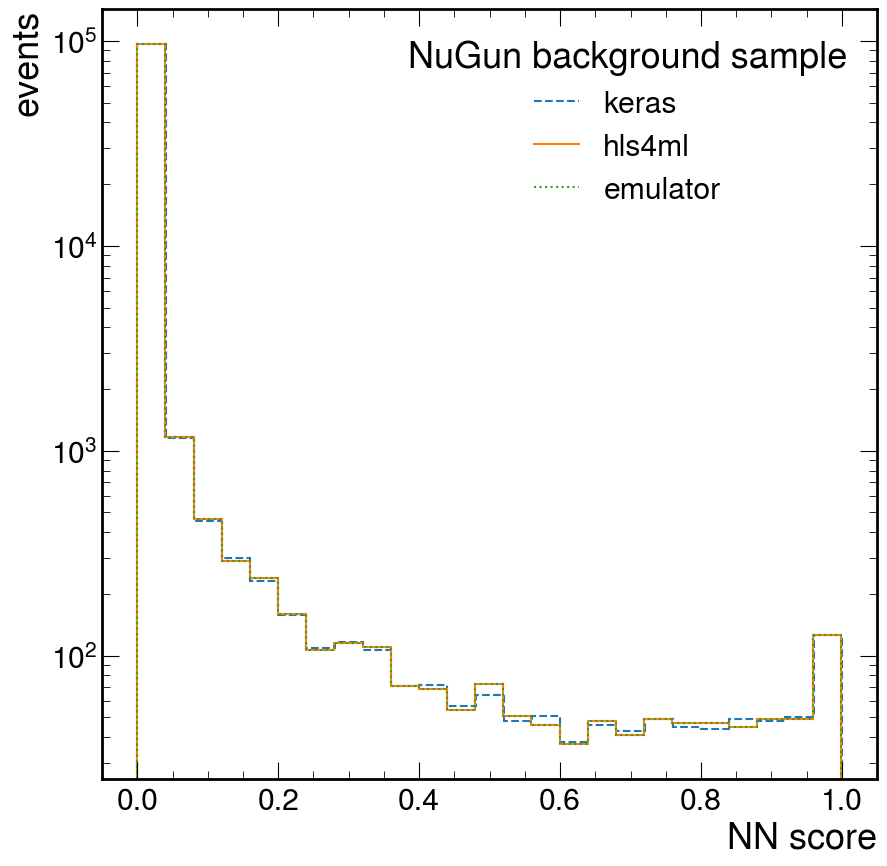

In [15]:
fig, ax = plt.subplots()

plotHist(y_pred_keras, label="keras", ax=ax, bins=25, linestyle="--")
plotHist(y_pred_hls4ml, label="hls4ml", ax=ax, bins=25)
plotHist(y_pred_emu, label="emulator", ax=ax, bins=25, linestyle=":")

ax.set_yscale("log")
ax.set_xlabel("NN score")

plt.legend(title="NuGun background sample")
plt.show()